<a href="https://colab.research.google.com/github/GauraoM/PyTorch/blob/main/Residual%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
# Download the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [3]:
# Extract the file
with tarfile.open("/content/cifar10.tgz","r:gz") as tar:
  tar.extractall(path = ".")

In [4]:
data_dir = "/content/cifar10"

# get the folders
print(os.listdir(data_dir))
# get the folders inside the classes
classes = os.listdir(data_dir + "/train") 
print(classes)

['test', 'train']
['deer', 'truck', 'cat', 'frog', 'airplane', 'dog', 'automobile', 'ship', 'bird', 'horse']


In [5]:
# Printing files from folder
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of planes:", len(airplane_files))
print(airplane_files[:5]) 

No. of planes: 5000
['0157.png', '4222.png', '0730.png', '3399.png', '0061.png']


In [6]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of planes:", len(ship_test_files))
print(ship_test_files[:5])

No. of planes: 1000
['0157.png', '0730.png', '0061.png', '0640.png', '0345.png']


In [7]:
## ImageFolder class from torchvision to load the dataset as pytorch tensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [8]:
## Data Transform (Normalization and data agumentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode="reflect"),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)
                         ])

valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [9]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir + "/train", train_tfms)
valid_ds = ImageFolder(data_dir + "/test", valid_tfms)

In [10]:
from torch.utils.data import DataLoader

In [11]:
batch_size = 256

In [12]:
# Pytorch dataloader
# num_workers = no. of cores of cpu/gpu to utilize for pareallel operations
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers=8, pin_memory=True)

valid_dl = DataLoader(valid_ds, batch_size, shuffle = False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [14]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize =(16,16))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images[:100],10).permute(1,2,0))
    break

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out+x)

In [17]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 32, 32])


In [18]:
from torch.nn.modules.batchnorm import BatchNorm2d
def conv_2d(ni, nf, stride=1, ks=3):
  return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
  return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace=True),conv_2d(ni, nf))

class ResidualBlock(nn.Module):
  def __init__(self, ni, nf, stride=1):
    super().__init__()
    self.bn = nn.BatchNorm2d(ni)
    self.conv1 = conv_2d(ni, nf, stride)
    self.conv2 = bn_relu_conv(nf,nf)
    self.shortcut = lambda x:x
    if ni != nf:
      self.shortcut = conv_2d(ni, nf, stride, 1)

  def forward(self,x):
    x = F.relu(self.bn(x), inplace=True)
    r = self.shortcut(x)
    x = self.conv1(x)
    x = self.conv2(x) * 0.2
    return x.add_(r)

In [19]:
def make_group(N, ni, nf, stride):
  start = ResidualBlock(ni, nf, stride)
  rest = [ResidualBlock(nf, nf) for j in range(1,N) ]
  return [start] + rest

class Flatten(nn.Module):
  def __init__(self): super().__init__()
  def forward(self,x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
    super().__init__()
    # Increase channels to n_start using conv layer
    layers = [conv_2d(3, n_start)]
    n_channels = [n_start]

    # Add groups of BasicBlock(increase channels and downsample)
    for i in range(n_groups):
      n_channels.append(n_start*(2**i)*k)
      stride = 2 if i>0 else 1
      layers += make_group(N, n_channels[i], n_channels[i+1], stride)

    # Pool. faltten and add linear layers for classification
    layers += [nn.BatchNorm2d(n_channels[3]),
               nn.ReLU(inplace=True),
               nn.AdaptiveAvgPool2d(1),
               Flatten(),
               nn.Linear(n_channels[3], n_classes)] 

    self.features = nn.Sequential(*layers)

  def forward(self, x): return self.features(x)

def wrn_22():
  return WideResNet(n_groups=3, N=3, n_classes=10, k=6)


In [20]:
model = wrn_22()

In [21]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [22]:
# lets see an example
for images, labels in train_dl:
    print('images.shape',images.shape)
    out = model(images)
    print('out.shape',out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([256, 3, 32, 32])
out.shape torch.Size([256, 10])


In [23]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

####First we create DataBunch object to using the DataLoader we created previously and then we created a learner object using the DataBunch, model and loss function

In [24]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path = "/content/cifar10")
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [25]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


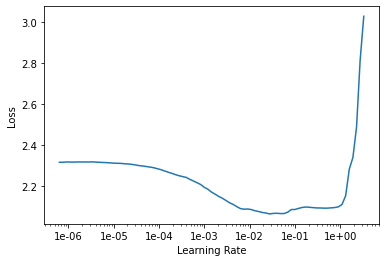

In [26]:
learner.recorder.plot()

####To train the model using 1-cycle policy, we .fit_one_cycle method, pass the no. of epochs and maximum learning rate. We also use weight decay, which is another regularization parameter which prevents the weight from becoming too large by adding an additional term to the loss function.

In [27]:
learner.fit_one_cycle(5,1e-01,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.219334,1.369048,0.551700,05:26
1,0.899401,1.010078,0.664900,05:25
2,0.652211,0.700596,0.763700,05:24
3,0.462555,0.421031,0.855600,05:24
4,0.350748,0.372608,0.873500,05:24


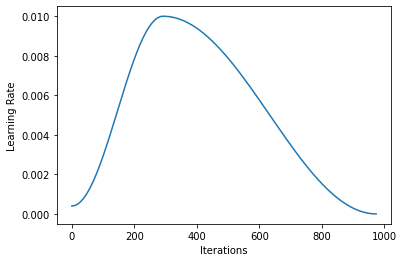

In [28]:
learner.recorder.plot_lr()

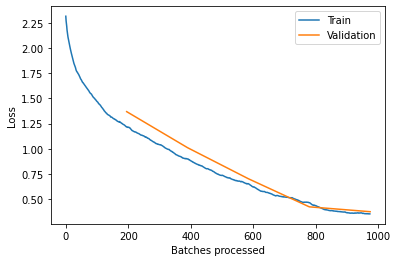

In [29]:
learner.recorder.plot_losses()

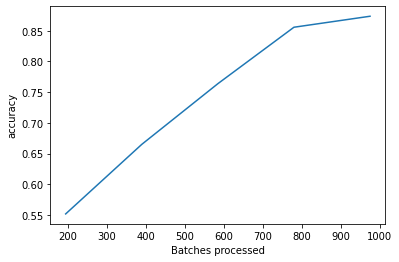

In [30]:
learner.recorder.plot_metrics()